# Notebook to develop Skeleton Methods Code

In [9]:
import numpy as np
import pandas as pd
import scipy
import math

In [10]:
def distance_mat(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

from scipy.spatial import distance_matrix

## Simulation Datasets

In [11]:

def twoMoon(numObjects = 180, shape1a = -0.4, shape2b = 1, shape1rFrom = 0.8, shape1rTo = 1.2, shape2rFrom = 0.8, shape2rTo = 1.2):
    """
    Generating twoMoon data

    Parameters
    ----------
    
    Returns
    -------
    """
    nrow = numObjects*2
    x =  np.array([[0.0 for col in range(2) ] for row in range(nrow)])
    for i in range(nrow):
        alpha = np.random.uniform(low=0.0, high=2*math.pi) 
        if i >= numObjects:
            r = np.random.uniform(shape2rFrom, shape2rTo)
        else:
            r = np.random.uniform(shape1rFrom, shape1rTo)
        tmp1 = r * math.cos(alpha)
        tmp2 = r * math.sin(alpha)
        if i < numObjects:
            x[i, 0] = shape1a + abs(tmp1)
            x[i, 1] = tmp2
        else:
            x[i, 0] = -abs(tmp1)
            x[i, 1] = tmp2 - shape2b
    
    label = np.array([0 for row in range(numObjects)]+ [1 for row in range(numObjects)])
    return {"data": x, "label" :label}


In [12]:
from numpy.random import multivariate_normal
from numpy.random import normal
from numpy.random import uniform

In [13]:
#' Generating Yinyang data
#'
#' @param n_m number of points in each of the two moon shapes. Positive integer value or vector with length=2
#' @param n_c number of points in each of the two small circles
#' @param n_r number of points in the outer ring
#' @param sd_c the standard deviation of shifts for points in the two small circles
#' @param sd_r the standard deviation of shifts for points in the outer ring
#' @param d a number indicating the dimension of the generated data. d>2 dimensions are filled with independent Gaussian noises
#' @param sd_high a number indicating the standard deviation for Gaussian noises in the higher dimensions
#' @return A list of generated data points and the true labels
#'   \item data - The generated data matrix
#'   \item clus - The vector of true cluster labels for each data point
def Yinyang_data(n_m=400,n_c=200,n_r=2000,var_c=0.01,sd_r=0.1, d=2, sd_high=0.1):
    X_m = twoMoon(numObjects = n_m)
    
    X1= multivariate_normal([0.5, -1.5], [[var_c, 0.0], [0.0, var_c]], n_c)
    X2= multivariate_normal([-1, 0.5], [[var_c, 0.0], [0.0, var_c]], n_c)

    th = uniform(0,2*math.pi, n_r)
    X31 = 2.5*np.cos(th) - 0.25 + normal(0, sd_r, n_r)
    X32 = 2.5*np.sin(th) -0.5 + normal(0, sd_r, n_r)

  
    X = np.vstack((X_m["data"], X1, X2, np.stack((X31, X32), axis=-1)))
    if d>2:
      noised = normal(0, sd_high, size = (len(X), int(d-2)))
      X = np.hstack((X, noised))

    label = np.concatenate((X_m["label"], [2 for _ in range(n_c)] ,  [3 for _ in range(n_c)] , [4 for _ in range(n_r)] ), axis=None)
    
    return {"data": X, "label" :label}
    

In [14]:
data = Yinyang_data()

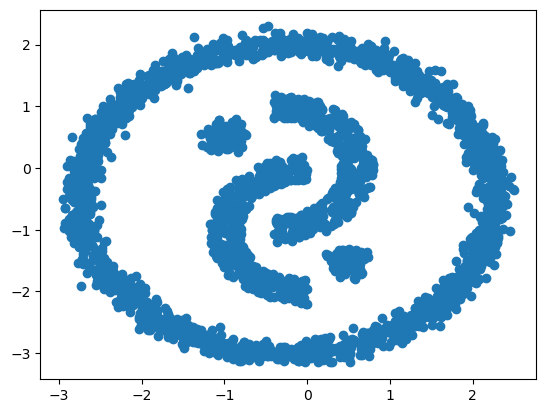

In [15]:
import matplotlib.pyplot as plt
plt.scatter(data["data"][:,0], data["data"][:,1])
plt.axis()
plt.show()

In [16]:
data = twoMoon()
X = data["data"]
Y = data["label"]

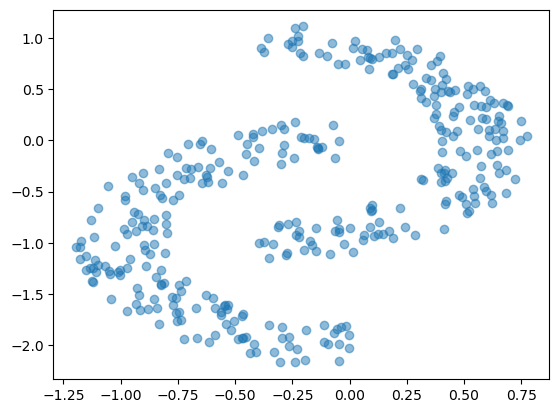

In [17]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

## Construct knots using overfitting kMeans

In [18]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import collections


In [19]:
def constructKnots(X, centers = None, labels = None, k = None, rep = 100):
  """
    construct knots using overfitting kMeans

    Parameters
    ----------
    X : np.array
        the data ndarray
    centers: np.array of the knots, can be provided
    labels: np.array of the knot label that each data point belongs to
    k: the number of knots
    rep: times of random initialization for kMeans

    Returns
    -------
    centers: ndarray of the constructed knots
    cluster: array of knot labels to which the data points belong to
    nknots: number of knots
    withinss: within cluster sum of squares for each Voronoi cell corresponding to the knots
  """
  n, d = X.shape
  #construct knots
  if centers is None and labels is None:
    # Overfitting k-means
    #setting the number of knots k
    if k is None:
      k = round(math.sqrt(n))

    km = KMeans(n_clusters = k, n_init = rep)
    km.fit(X)
    centers = km.cluster_centers_
    labels = km.labels_

  elif labels is None:#centers provided but not labels
    nbrs = NearestNeighbors(n_neighbors=1).fit(centers)
    labels = nbrs.kneighbors(X, return_distance=False)
    k = len(centers)
    
  elif centers is None:#labels provided but not centers
    elements_count = collections.Counter(labels)
    k = len(elements_count.items())
    centers = np.array([[0.0 for col in range(d)] for row in range(k)])
    for key, value in elements_count.items():
      centers[key,] = np.mean(X[labels == key,], axis=0)

  else:
    k = len(centers)
  

  withinss = np.array([0.0]*k)
  for i in range(k):
    withinss[i] = np.sum((X[labels == i,]-centers[i,])**2)

  return {"centers":centers, "cluster":labels, "nknots":k, "withinss": withinss}

In [20]:
conKnots = constructKnots(X)

In [21]:
knots = conKnots["centers"]
knotlabels = conKnots["cluster"]
k = conKnots["nknots"]
withinss = conKnots["withinss"]

## Construct edge weights with different measures

In [22]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

In [23]:
def skelWeights(X, conKnots, wedge= "all", h = "silverman", R0 = None, idx_frustum = False):
  """
    calculate weights based on constructed skeleton

    Parameters
    ----------
    X : np.array of the data ndarray
    conKnots: list object returned by constructKnots
    wedge: which edge measure to include
    h: a number or string for the bandwidth for KDE used for Face and Tube density
    R0: disk radius for Tube density
    idx_frustum: whether setting same disk radius for all edges

    Returns
    -------
    nn: indices of the 2 nearest knots for each data point
    voron_weights: voronoi density weights between the knots
    face_weights: face density weights between the knots
    frustum_weights: Tube density weights between the knots. Called frustum as for different radii for different knots.
    R: radius used for Tube density
    avedist_weights: average distance density weights between the knots
  """
  m = conKnots["nknots"]
  knots = conKnots["centers"]
  knotlabels = conKnots["cluster"]
  withinss = conKnots["withinss"]

  #identify what edge weights to include
  edge_include = [False]*4
  if wedge == 'all':
    edge_include = [True]*4
  else:
    edge_include = np.isin(['voronoi', 'face', 'frustum', 'avedist'], wedge )
  
  #edge weight matrices
  if edge_include[0]:
    voron_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[1]:
    face_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[3]:
    avedist_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[2]:
    frustum_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
    ### setting the threshold for each disk
    if R0 is None: #fill in average within cluster variance if not specified
      elements_count = collections.Counter(knotlabels)
      knotsizes = np.array([0]*m)
      for key, size in elements_count.items():
        knotsizes[key] = size
      R_cluster = np.sqrt(withinss/(knotsizes-1))
      R0 = np.mean(R_cluster)
      if idx_frustum: #same radius for all knots
        R0_lv = np.array([R0]*m)
      else: #different radius for each knot
        R0_lv = R_cluster
    elif len(R0)== 1: # only one specified R0
      R0_lv = np.array([R0]*m)
      idx_frustum = True
    elif len(R0) == m:
      R0_lv = R0
      idx_frustum = False
    else:
      elements_count = collections.Counter(knotlabels)
      knotsizes = np.array([0]*m)
      for key, size in elements_count.items():
        knotsizes[key] = size
      R_cluster = np.sqrt(withinss/(knotsizes-1))
      R0 = np.mean(R_cluster)
      if idx_frustum: #same radius for all knots
        R0_lv = np.array([R0]*m)
      else: #different radius for each knot
        R0_lv = R_cluster



  # calculate 2 Nearest Neighbor Indices
  nbrs = NearestNeighbors(n_neighbors=2).fit(knots)
  X_nn = nbrs.kneighbors(X, return_distance=False) #2-nearest neighbor calculation

  for i in range(m-1): #loop through knots pairs
    center1 = knots[i]
    wi1 = np.where(X_nn[:,0] == i)[0]
    wi2 = np.where(X_nn[:,1] == i)[0]
    for j in range(i+1,m):
      center2 = knots[j]
      wj1 = np.where(X_nn[:,0] == j)[0]
      wj2 = np.where(X_nn[:,1] == j)[0]
      #data point indices within 2nn neighborhood of knots i, j
      nn2ij = np.union1d(np.intersect1d(wi1, wj2), np.intersect1d(wi2, wj1))
  
      if len(nn2ij) < 1 :#not in Delaunnay Triangulation
        if edge_include[0]:
          voron_weights[i,j] = 0.0
        if edge_include[1]:
          face_weights[i,j] = 0.0
        if edge_include[2]:
          frustum_weights[i,j] = 0.0
        if edge_include[3]:
          avedist_weights[i,j] = 0.0
        continue
      
      # Euclidean distance between two centers
      d12 = np.sqrt(sum((center1-center2)**2))

      #compute the Voronoi density 
      if edge_include[0]: 
        voron_weights[i,j] = len(nn2ij)/d12
      
      #compute the face density
      if edge_include[1]:
        v0 = (center2-center1)/d12 #direction vector
        X_ij = X[np.union1d(wi1, wj1)]
        p0_length = np.dot(X_ij-(center1+center2)/2,v0 )  #projected distance to middle point of the edge
        p_dot = p0_length/d12 #standardize the projected distances into proportions
        
        kde = gaussian_kde(p_dot, bw_method=h) #KDE with projected points
        face_weights[i,j] = kde.evaluate([0]) #interpolated density at middle point
        #end face density calculation
      
      #compute tube density
      if edge_include[2]: 
        if not edge_include[1]: # recompute some quantities in Face density calculation
          v0 = (center2-center1)/d12 #direction vector
          X_ij = X[np.union1d(wi1, wj1)]

        p1_length = np.dot(X_ij-center1,v0 )  # length to center1 after projection
        p1_dot = p1_length/d12 #standardize the projected distances into proportions
        perp_length = np.sqrt(np.sum((X_ij -center1)**2, axis=1)-p1_length**2) #orthogonal distance to the center-passing line
    
        #threshold for each datapoint
        R0_threshold = R0_lv[i] + (R0_lv[j]-R0_lv[i])*p1_dot
        w_edge = np.where(perp_length<R0_threshold)#points that can be used in KDE
        
        if len(w_edge)>1: #KDE works with more than 1 data point
          kde = gaussian_kde(p1_dot[w_edge], bw_method=h) #KDE with projected points
          # finding the minimal density
          frustum_weights[i,j] = min(kde.evaluate(np.linspace(0.0, 1.0, num=100)))
      #end frustum density calculation

      # compute avedist density
      if edge_include[3]: 
        dists = distance_matrix(X[wi1,], X[wj1,])
        avedist_weights[i,j] = np.mean(dists)
      #end avedist density

  output = {"nn": X_nn}
  if edge_include[0]:
    output.update( {"voron_weights": voron_weights + np.transpose((voron_weights))})
  if edge_include[1]:
    output.update( {"face_weights": face_weights + np.transpose((face_weights))})
  if edge_include[2]:
    output.update( {"frustum_weights": face_weights + np.transpose((frustum_weights))})
    output.update( {"R": R0_lv})
  if edge_include[3]:
    output.update( {"avedist_weights": avedist_weights })
  
  return(output)
  
    
    

## Summarize as a overall function to construct weighted skeleton

In [24]:
#' Construct the skeleton representation of a dataset
#'
#' @param data a matrix/dataframe of data points.
#' @param centers an optional matrix/dataframe of the knots in the skeleton representation.
#' @param labels an optional numeric vector of skeleton membership labels for each data points.
#' @param k a number indication the numer of knots to use for skeleton representation.
#' @param rep a number indicating the repetition when overfitting kmeans to choose knots.
#' @param wedge a character or a vector of characters indicating the types of edge measure weights to include.
#' Can take 'all', 'none', 'voronoi', 'face', 'frustum', 'avedist'.
#' @param h a number for the bandwidth when using KDE to calculate Face or Frustum density.
#' @param kernel a character string giving the smoothing kernel to be used in KDE. Same as in the density function. This must partially match one of "gaussian", "rectangular", "triangular", "epanechnikov", "biweight", "cosine" or "optcosine", with default "gaussian", and may be abbreviated to a unique prefix.
#' @param R0 a number indicating the disk radius for Frustum density
#' @param idx_frustum  logical; if TRUE, use same disk radius for different pairs of knots. If FALSE, use different within cluster variance as radius
#' @return A list with following components:
#' \describe{
#'   \item{centers}{The matrix of the skeleton knots.}
#'   \item{cluster}{The numeric vector indicating the neareast knot for each point.}
#'   \item{nknots}{The number indicating the number of knots.}
#'   \item{voron_weights}{The matrix of Voronoi density weights for edges in the skeleton.}
#'   \item{face_weights}{The matrix of Face density weights for edges in the skeleton.}
#'   \item{frustum_weights}{The matrix of Tube/Frustum density weights for edges in the skeleton.}
#'   \item{avedist_weights}{The matrix of Average Distance weights for edges in the skeleton.}
#'   \item{bw}{The bandwidth used for Face and Frustum density calculation. }
#'   \item{R}{The disk radius used for Frustum density calculation. }
#' }
def Skeleton_Construction(X, centers = None, labels = None, k = None, rep = 100, 
                            wedge= "all", h = "silverman", R0 = None, idx_frustum = False):

    conKnots = constructKnots(X, centers, labels, k, rep = 100)
    output = conKnots
    if wedge is not None:
        edgeWeights = skelWeights(X, conKnots, wedge, h, R0, idx_frustum)
        output.update(edgeWeights)
    return(output)

        


In [25]:
skeleton = Skeleton_Construction(X)

## Hierarchical clustering using skeleton weights

In [26]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_rand_score

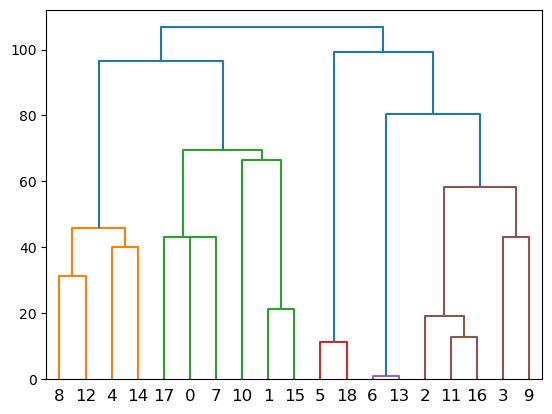

In [27]:
### Voronoi density
p_dist = np.max(skeleton["voron_weights"])+1 - skeleton["voron_weights"]
np.fill_diagonal(p_dist, 0.0)
condense_dist= squareform(p_dist, checks=False)
hclust = linkage(condense_dist, "single")
dendrogram(hclust)
plt.show()
voron_labels = fcluster(hclust, 2, criterion='maxclust') # membership for knots
X_labs = np.array(voron_labels)[np.array(skeleton["cluster"])] # labels for each data point
voron_rand = adjusted_rand_score(X_labs, Y)



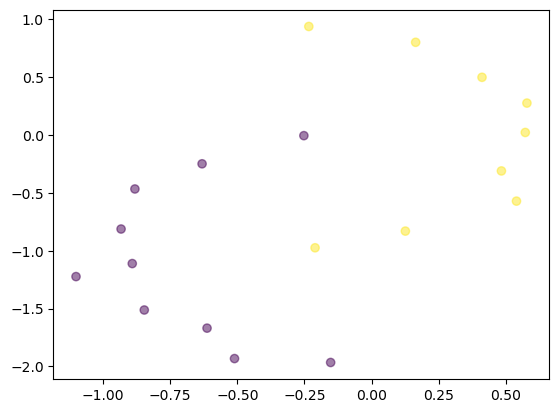

In [28]:
knots = skeleton["centers"]
plt.scatter(knots[:,0], knots[:,1], alpha=0.5, c = voron_labels)
plt.show()


In [185]:
def cluster_weights(weights, Xknotcluster, kcut, Y=None, method="single"):
  """
    perform clustering using the skeleton-based weights

    Parameters
    ----------
    weights : ndarray of the edge weights to cluster based on
    Xknotcluster: array of knot labels where each data point belongs to
    kcut: the number of resulting disconnected components
    Y: true class labels. Used to calculate performance
    method: linkage method for hierarchical clustering

    Returns
    -------
    a list with the clustering results
  """
    p_dist = np.max(weights)+1 - weights
    np.fill_diagonal(p_dist, 0.0)
    condense_dist= squareform(p_dist, checks=False)
    hclust = linkage(condense_dist, method)
    knot_labs = fcluster(hclust, kcut, criterion='maxclust') # membership for knots
    X_labs = np.array(knot_labs)[np.array(Xknotcluster)] # labels for each data point
    if Y is None:
        adj_rand = None
    else:
        adj_rand = adjusted_rand_score(X_labs, Y)
    return({"hclust":hclust, "knot_labs":knot_labs, "X_labs":X_labs, "adj_rand":adj_rand})

In [30]:
voron_clus = cluster_weights(skeleton["voron_weights"], skeleton["cluster"],  2, Y)

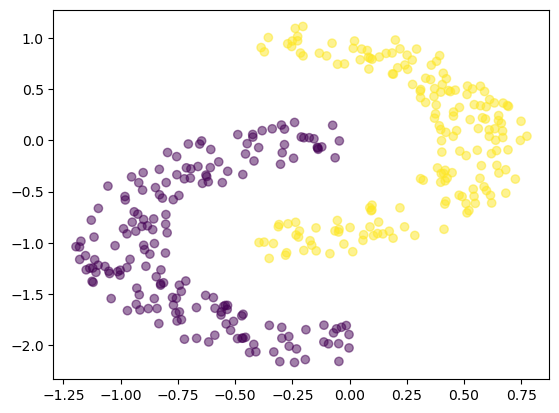

In [31]:
plt.scatter(X[:,0], X[:,1], alpha=0.5, c = voron_clus["X_labs"])
plt.show()

## Segment skeleton with hierarchical clustering results

In [32]:
import igraph

In [33]:
def segment_Skeleton(skeleton,  wedge = "voron_weights", kcut=1, cut_method = "single", tol = 1e-10):
  """
    segment the skeleton graph of a dataset based on edge weights

    Parameters
    ----------
    skeleton: obejct resulting from Skeleton_Construction()
    wedge: which edge weights used to segment skeleton
    kcut: the number of resulting disconnected components
    cut_method: linkage method for hierarchical clustering
    tol: tolerance for float error

    Returns
    -------
    Adding items to the skeleton:
    kkdists: Euclidean distances between knots
    cutWeights: The weight matrix with values for cut edges set to 0
    g: the igraph object of the segmented skeleton

  """
  knots = skeleton["centers"]
  X_knotlabels = skeleton["cluster"]

  #similarities
  weights = skeleton[wedge]
  hclustKnot = cluster_weights(weights, X_knotlabels, kcut = kcut, method=cut_method)


  #choose correct cut
  cutheight = hclustKnot["hclust"][-kcut][2]
  #cut some edges
  weights[weights<(np.max(weights)-cutheight+tol)] = 0

  #Euclidean distance between centers
  kkdists = distance_matrix(knots,knots)
  kkdists[weights == 0] = 0

  # ###############################################
  # # get the graph based on Euclidean similarities
  # ###############################################
  g = igraph.Graph.Weighted_Adjacency(kkdists.tolist(),  mode='undirected')
  # layout = g.layout("coords_fr")
  # import matplotlib.pyplot as plt
  # fig, ax = plt.subplots()
  # layout = g.layout("kk")
  # igraph.plot(g, layout=layout, target=ax)
  skeleton.update({"kkdists": kkdists, "cutWeights": weights, "g" :g}) 
  return(skeleton)

In [34]:
segSkeleton = segment_Skeleton(skeleton,  kcut=2)

In [35]:
skeleton = segSkeleton

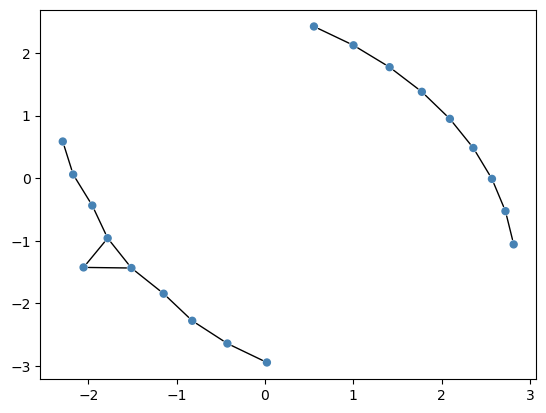

In [36]:
g = segSkeleton["g"]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
layout = g.layout("kk")
igraph.plot(g, layout=layout, target=ax)

## Project data points onto skeleton

In [37]:
def skelProject(X, skeleton, nn = None):
  """
    Project data points onto the skeleton

    Parameters
    ----------
    X: the matrix of the data points to be projected
    skeleton: a list returned by segment_Skeleton()
    nn: the matrix where each row records the indices of the two closest centers of the corresponding data point.


    Returns
    -------
    A vector where each entry records the projection proportion of the corresponding data point 
    on the edge by the two closest knots, from the smaller index knot. NA if the two closest knots not connected.

  """
  knots = skeleton["centers"]
  kkdists = skeleton["kkdists"]
  g = skeleton["g"]
  n = len(X)

  if nn is None:
    nbrs = NearestNeighbors(n_neighbors=2).fit(knots)
    nn = nbrs.kneighbors(X, return_distance=False) #2-nearest neighbor calculation

  #calculate the projection for each data point
  #a proportion between [0,1] is recorded
  px = [None]*n
  for i in range(n):
     #begin calculate the projection for each data point
    if g.are_connected(nn[i,0], nn[i,1]):
      #if the two nearest knots are connected
      k0 = np.min(nn[i,:])
      k1 = np.max(nn[i,:])
      #directional vector
      #always use the smaller index as the starting point
      v = (knots[k1,:]-knots[k0,:])/kkdists[k0,k1]
      prop = np.dot(X[i,:]-knots[k0,], v)/kkdists[k0,k1] #projected proportion
      px[i] = max(min(prop, 1),0) #confine to [0,1]
    #leave the projection to knot cases as None
  
  return(px)


In [38]:
px = skelProject(X, segSkeleton, nn = segSkeleton["nn"])

## Compute skeleton based distance between points on the skeleton

In [39]:
#' skeleton distance calculation
#' , , , , ,
#' @param nnc1 a vector of the indexes of the two nearest neighbors of one point.
#' @param nnc2 a vector of the indexes of the two nearest neighbors of another point.
#' @param px1 the projection proportion of point 1 onto the edge by its two nearest knots, with the lower index knot as the origin.
#' @param px2 the projection proportion of point 2 onto the edge by its two nearest knots, with the lower index knot as the origin.
#' @param skeleton a list returned by the voronSkeleton method constructing the skeleton graph.
#' @return skeleton-based distance between two points on the skeleton
def dskeleton(nnc1, nnc2, px1, px2, skeleton):
  g = skeleton["g"]
  kkdists = skeleton["kkdists"]

  #simplify calculation by only focusing on pair of points sharing at least one knot
  if len(np.intersect1d(nnc1,nnc2))<1:
    return(float('inf'))
  #case when both data points cannot be projected onto an edge
  elif px1 is None and px2 is None:
    # g.shortest_paths(nnc1[0], nnc2[0], weights='weight') #for general graph distance
    return(kkdists[nnc1[0], nnc2[0]])
  #case when point id1 can be projected onto an edge but not point 2
  elif px1 is not None and px2 is None:
    btnodes1 = g.shortest_paths(nnc1[0], nnc2[0], weights='weight')[0][0]
    btnodes2 = g.shortest_paths(nnc1[1], nnc2[0], weights='weight')[0][0]
    if not math.isfinite(btnodes1) and not math.isfinite(btnodes2):
      return(float('inf'))
    elif btnodes1 < btnodes2:#shortest path from nnc1[0]
      if nnc1[0] < nnc1[1]: #nnc1[0] is the reference point for projection
        return(btnodes1 + kkdists[nnc1[0], nnc1[1]]*px1 )
      else:
        return(btnodes1 + kkdists[nnc1[0], nnc1[1]]*(1-px1) )
    else: ##shortest path from nnc1[1], btnodes2 < btnodes1
      if nnc1[0] < nnc1[1]: #nnc1[0] is the reference point for projection
        return(btnodes2 + kkdists[nnc1[0], nnc1[1]]*(1-px1) )
      else:
        return(btnodes2+ kkdists[nnc1[0], nnc1[1]]*px1 )
  #case when point id2 can be projected onto an edge
  elif px1 is None and px2 is not None:
    btnodes1 = g.shortest_paths(nnc1[0], nnc2[0], weights='weight')[0][0]
    btnodes2 = g.shortest_paths(nnc1[0], nnc2[1], weights='weight')[0][0]
    if not math.isfinite(btnodes1) and not math.isfinite(btnodes2):
      return(float('inf'))
    elif btnodes1 < btnodes2:#shortest path from nnc2[0]
      if nnc2[0] < nnc2[1]: #nnc2[0] is the reference point for projection
        return(btnodes1 + kkdists[nnc2[0], nnc2[1]]*px2 )
      else:
        return(btnodes1 + kkdists[nnc2[0], nnc2[1]]*(1-px2) )
    else: ##shortest path from nnc2[1], btnodes2 < btnodes1
      if nnc2[0] < nnc2[1]: #nnc2[0] is the reference point for projection
        return(btnodes2 + kkdists[nnc2[0], nnc2[1]]*(1-px2) )
      else:
        return(btnodes2+ kkdists[nnc2[0], nnc2[1]]*px2 )
  else: #case when both points are projected onto edges
    btnodes = [g.shortest_paths(nnc1[0], nnc2[0], weights='weight')[0][0],
    g.shortest_paths(nnc1[0], nnc2[1], weights='weight')[0][0],
    g.shortest_paths(nnc1[1], nnc2[0], weights='weight')[0][0],
    g.shortest_paths(nnc1[1], nnc2[1], weights='weight')[0][0]
    ]
    if np.all(np.invert(np.isfinite(btnodes))): #all are infinite
      return(float('inf'))

    idmin = np.argmin(btnodes)
    temp = np.min(btnodes)
    if idmin == 0: #nnc1[0] and nnc2[0] are the closest
      if nnc1[0] < nnc1[1]:#nnc1[0] is the reference point for id1 projection
        temp = temp + kkdists[nnc1[0], nnc1[1]]*px1
      else:
        temp = temp + kkdists[nnc1[0], nnc1[1]]*(1-px1)
      if nnc2[0] < nnc2[1]: #nnc2[0] is the reference point for id2 projection
        temp = temp + kkdists[nnc2[0], nnc2[1]]*px2
      else:
        temp = temp + kkdists[nnc2[0], nnc2[1]]*(1-px2)
      return(temp)
    elif idmin == 1: #nnc1[0] and nnc2[1] are closest
      if nnc1[0] < nnc1[1]:#nnc1[0] is the reference point for id1 projection
        temp = temp + kkdists[nnc1[0], nnc1[1]]*px1
      else:
        temp = temp + kkdists[nnc1[0], nnc1[1]]*(1-px1)
      if nnc2[0] < nnc2[1]: #nnc2[0] is the reference point for id2 projection
        temp = temp + kkdists[nnc2[0], nnc2[1]]*(1-px2)
      else:
        temp = temp + kkdists[nnc2[0], nnc2[1]]*px2
      return(temp)
    elif idmin == 2: #nnc1[1] and nnc2[0] are closest
      if nnc1[0] < nnc1[1]:#nnc1[0] is the reference point for id1 projection
        temp = temp + kkdists[nnc1[0], nnc1[1]]*(1-px1)
      else:
        temp = temp + kkdists[nnc1[0], nnc1[1]]*px1
      if nnc2[0] < nnc2[1]:#nnc2[1] is the reference point for id2 projection
        temp = temp + kkdists[nnc2[0], nnc2[1]]*px2
      else:
        temp = temp + kkdists[nnc2[0], nnc2[1]]*(1-px2)
      return(temp)
    else: #nnc1[2] and nnc2[2] are closest
      if nnc1[0] < nnc1[1]: #nnc1[1] is the reference point for id1 projection
        temp = temp + kkdists[nnc1[0], nnc1[1]]*(1-px1)
      else:
        temp = temp + kkdists[nnc1[0], nnc1[1]]*px1
      if nnc2[0] < nnc2[1]: #nnc2[0] is the reference point for id2 projection
        temp = temp + kkdists[nnc2[0], nnc2[1]]*(1-px2)
      else:
        temp = temp + kkdists[nnc2[0], nnc2[1]]*px2
      return(temp)

In [42]:
nn = skeleton["nn"]
dskeleton(nn[0], nn[4], px[0], px[4], segSkeleton)

0.4892694239237796

### Pairwise version

In [45]:
#pairwise skeleton-based distance
def pairdskeleton(xnn, ynn, px,  py, skeleton):
  """
    pairwise skeleton-based distance

    Parameters
    ----------
    xnn/ ynn: the matrix where each row records the indices of the two closest centers of the corresponding data point.
    px/ py: projecting proportions as returned by skelProject()
    skeleton: a list returned by segment_Skeleton()


    Returns
    -------
    pairwise skeleton-based distances between the two sets of points on the skeleton.

  """
  xydists = np.array([[float('inf') for col in range(len(py))] for row in range(len(px))])
  for i in range(len(px)):
    #calculate graph distances between knots and sample points
    for j in range(len(py)):
      xydists[i,j] = dskeleton(xnn[i,], ynn[j,],  px[i], py[j], skeleton = skeleton)

  return(np.array(xydists))

In [46]:
nn = skeleton["nn"]

nbrs = NearestNeighbors(n_neighbors=2).fit(knots)
knotnn = nbrs.kneighbors(knots, return_distance=False) #2-nearest neighbor calculation
knotpx=skelProject(knots, skeleton, nn = knotnn)

xkdists = pairdskeleton( knotnn,nn,  knotpx, px,  skeleton)

## Implementing S-kernel regressor

In [47]:
def hns(x, deriv = 0):
  """
    compute the normal scale kernel bandwidth

    Parameters
    ----------
    x: array of values
    deriv: derivative orders used for calculation


    Returns
    -------
    the normal scaling bandwidth

  """
  n = len(x)
  if n < 1:
      return np.nan
  d = 1
  r = deriv
  h = (4/(n * (d + 2 * r + 2)))**(1/(d + 2 * r + 4)) * np.std(x)
  return(h)

In [48]:
def skelBand(xkdists):
  """
    compute the bandwidth for skeleton kernel regression

    Parameters
    ----------
    xkdists: skeleton-based distances between the datapoints and the knots

    Returns
    -------
    the bandwidth

  """
  k = len(xkdists)
  knotbands = [0.0 for _ in range(k)]
  for i in range(k):
    knotbands[i] = hns(xkdists[i,np.isfinite(xkdists[i,])])

  return(np.nanmean(knotbands))



In [49]:
skelBand(xkdists)

0.08770684297677157

In [50]:
nbrs = NearestNeighbors(n_neighbors=2).fit(knots)
knotnn = nbrs.kneighbors(knots, return_distance=False) #2-nearest neighbor calculation
knotpx=skelProject(knots, skeleton, nn = knotnn)

xkdists = pairdskeleton( knotnn,nn,  knotpx, px,  skeleton)
hreg = skelBand(xkdists)

In [51]:
def epanechnikov_kernel(x,width):
    """
    For a point x_0 in x, return the weight for the given width.
    """
    def D(t):
        if t <= 1:
            #return 3/4*float(1-t*t) <== why doesn't this work?
            return float(1-t*t)*3/4
        else:
            return 0
    return D(abs(x)/width)

In [52]:
def tri_cube_kernel(x,width):
    def D(t):
        if t <= 1:
            return float(1-t*t*t)**3
        else:
            return 0
    return D(abs(x)/width)

In [53]:
def kernel_smoother(X,Y,kernel,bandwidth):
    """
    Generalization with custom kernel.
    
    Parameters:
        X: the vector of feature data
        x_0: a particular point in the feature space
        kernel: kernel function
        width: kernel width
    
    Return value:
        The estimated regression function at x_0.
    """
    kernel_weights = [kernel(x,bandwidth) for x in X]
    
    weighted_average = np.average(Y,weights=kernel_weights)
    return weighted_average

## S-kernel regressor with fixed bandwidth

In [187]:
#' Fitting the S-kernel regressor with fixed bandwidth
#'
#' @param h1 the fixed bandwidth for kernel regression
#' @param testX the matrix of the test data points.
#' @param testSkeldists the matrix of skeleton-based distances between test and training points.
#' @param trainY the responses of the training points.
#' @return A vector of predicted responses for the test points.
#' @export
def skelKernel(trainX, trainY,  testX, skeleton = None, hreg= None, testtraindists = None,
centers = None, labels = None, nknot = None, rep = 100, wedge = "voronoi", hden = "silverman", R0 = None, idx_frustum = False, #arguments for skeleton construction
wedge_cut = "voron_weights", kcut=1, cut_method = "single", #parameters to cut skeleton
tol = 1e-10
):
  """
  Generalization with custom kernel.
  
  Parameters:
      trainX: training covariates
      trainY: training response
      testX: test covariates
      skeleton: object resulting from segment_Skeleton()
      hreg: bandwidth for kernel smoothing regression
      testtraindists: matrix of skeleton-based distances between test and training data
  Parameters for Skeleton_Construction
  Parameters for segment_Skeleton

  
  Return value:
      The estimated regression values for test data.
  """
  if testtraindists is None:

    if skeleton is None:
      skeleton = Skeleton_Construction(trainX, centers = centers,labels = labels, k = nknot,  rep = rep, wedge= wedge, h = hden, R0 = R0, idx_frustum = idx_frustum)
      skeleton = segment_Skeleton(skeleton, wedge = wedge_cut, kcut=kcut, cut_method = cut_method)

    trainnn = skeleton["nn"]
    trainpx = skelProject(trainX, skeleton, nn = trainnn)

    nbrs = NearestNeighbors(n_neighbors=2).fit(skeleton["centers"])
    testnn = nbrs.kneighbors(testX, return_distance=False) #2-nearest neighbor calculation
    testpx=skelProject(testX, skeleton, nn = testnn)

    testtraindists = pairdskeleton(testnn,trainnn, testpx, trainpx,  skeleton)
    

  if hreg is None:
    nbrs = NearestNeighbors(n_neighbors=2).fit(skeleton["centers"])
    knotnn = nbrs.kneighbors(skeleton["centers"], return_distance=False) #2-nearest neighbor calculation
    knotpx=skelProject(skeleton["centers"], skeleton, nn = knotnn)
    try:
      trainpx
    except NameError: # calculate projection for trainX
      trainpx = skelProject(trainX, skeleton, nn = skeleton["nn"])
    xkdists = pairdskeleton( knotnn,skeleton["nn"],  knotpx, trainpx,  skeleton)
    hreg = skelBand(xkdists)
    if hreg < np.quantile(xkdists[np.isfinite(xkdists)], 0.1) or hreg > np.quantile(xkdists[np.isfinite(xkdists)], 0.5):
      hreg = np.quantile(xkdists[np.isfinite(xkdists)], 0.25)

  ntest =   len(testX)
  testfit = [0.0 for _ in range(ntest)]
  trainY = np.array(trainY)
  #predictions on test data
  for i in range(ntest):
    z = testtraindists[i,]
    useid = np.isfinite(z)
    z = z[useid]
    if len(z)==1: #happens when there is only 1 finite distance training point
      testfit[i] = trainY[useid][0]
    elif np.std(z) < tol: # case when all x are close, which happens on singly separated knot
      testfit[i] = np.mean(trainY[useid])
    else:
      kernel_weights = [scipy.stats.norm.pdf(val/hreg) for val in z]
      testfit[i] = np.average(trainY[useid],weights=kernel_weights)

  return(testfit)


In [57]:
trainX = X
trainY = Y
testX = X
skernel_pred = skelKernel(trainX, trainY,  testX, skeleton = skeleton, hreg= hreg)

## Fitting the S-Lspline regressor

In [59]:
from sklearn.linear_model import LinearRegression

In [193]:
#' Fitting the S-Lspline regressor
#'
#' @param newnn the matrix where each row records the indices of the two closest knots of the new test points.
#' @param newpx the projection proportion for the new test points.
#' @param px the projection proportion for the training points.
#' @param trainY the responses of the training points.
#' @param skeleton a list returned by the voronSkeleton method constructing the skeleton graph.
#' @return A list with following components:
#' \describe{
#'   \item{trainZ}{The transformed training data matrix.}
#'   \item{testZ}{The transformed test data matrix.}
#'   \item{model}{The lm object for the resulting regression model.}
#'   \item{pred}{The vector of predicted responses for the test points.}
#' }
def skelLinear(newnn, newpx, trainnn, trainpx, trainY, skeleton):
  numknots = skeleton["nknots"]
  ntrain = len(trainY)
  ntest = len(newpx)

  #modified data matrix for training data based projected values
  trainZ = np.array([[0.0  for col in range(numknots)] for row in range(ntrain) ])
  for i in range(ntrain):
    if trainpx[i] is None: #where the data point is projected to nearest knot
      trainZ[i,trainnn[i,0]] = 1
    else:
      k0 = np.min(trainnn[i,])
      k1 = np.max(trainnn[i,])
      #Y0 + px(Y1-Y0), hence px(Y1), (1-px)Y0
      trainZ[i, k0] = 1-trainpx[i] #*edgedists[k0,k1]
      trainZ[i, k1] = trainpx[i]

  #modified data matrix for test data based projected values
  testZ = np.array([[0.0  for col in range(numknots)] for row in range(ntest)] )
  for i in range(ntest):
    if newpx[i] is None: #where the data point is projected to nearest knot
      testZ[i,newnn[i,0]] = 1
    else:
      k0 = np.min(newnn[i,])
      k1 = np.max(newnn[i,])
      #Y0 + px(Y1-Y0), hence px(Y1), (1-px)Y0
      testZ[i, k0] = 1-newpx[i] #*edgedists[k0,k1]
      testZ[i, k1] = newpx[i]

  lmod = LinearRegression(fit_intercept= False).fit(trainZ, trainY)
  lmpred = lmod.predict(testZ)

  return({"trainZ": trainZ, "testZ":testZ, "model":lmod, "pred":lmpred})


In [85]:
newnn = nn
newpx = px
trainnn = nn
trainpx = px
trainY = Y
lspline = skelLinear(newnn, newpx, trainnn, trainpx, trainY, skeleton)

In [198]:
def skelLspline(trainX, trainY, testX, 
testnn = None, testpx = None, trainnn = None, trainpx=None, skeleton = None):
  """
  S-Lspline regression from raw data
  
  Parameters:
      trainX: training covariates
      trainY: training response
      testX: test covariates
      testnn/trainnn: indices of two nearest knots for test/train covariates
      testpx/trainpx: projection proportions for test/train covariates
      skeleton: object resulting from segment_Skeleton()
  
  Return value:
      The estimated regression results:
      trainZ: transformed training covariates
      testZ: transformed test covariates
      model: the regression model return from sklearn.linear_model.LinearRegression
      pred: predicted values for test data

  """
  if skeleton is None:
      skeleton = Skeleton_Construction(trainX)
      skeleton = segment_Skeleton(skeleton)
  if trainnn is None:
      trainnn = skeleton["nn"]
  if trainpx is None:
      trainpx = skelProject(trainX, skeleton, nn = trainnn)
  if testnn is None:
      nbrs = NearestNeighbors(n_neighbors=2).fit(skeleton["centers"])
      testnn = nbrs.kneighbors(testX, return_distance=False) #2-nearest neighbor calculation
  if testpx is None:
      testpx=skelProject(testX, skeleton, nn = testnn)
  
  return skelLinear(testnn, testpx, trainnn, trainpx, trainY, skeleton)


## Fitting the S-Qspline regressor

In [91]:

#' Fitting the S-Qspline regressor
#'
#' @param newnn the matrix where each row records the indices of the two closest knots of the new test points.
#' @param newpx the projection proportion for the new test points.
#' @param px the projection proportion for the training points.
#' @param trainY the responses of the training points.
#' @param skeleton a list returned by the voronSkeleton method constructing the skeleton graph.
#' @return A list with following components:
#' \describe{
#'   \item{trainZ}{The transformed training data matrix.}
#'   \item{testZ}{The transformed test data matrix.}
#'   \item{model}{The lm object for the resulting regression model.}
#'   \item{pred}{The vector of predicted responses for the test points.}
#' }
#' @export
def skelQuadratic(newnn, newpx, trainnn, trainpx, trainY, skeleton):
  numknots = skeleton["nknots"]
  ntrain = len(trainY)
  ntest = len(newpx)

  #modified data matrix for training data based projected values
  trainZ = np.array([[0.0  for col in range(2*numknots)] for row in range(ntrain) ])
  for i in range(ntrain):
    if trainpx[i] is None: #where the data point is projected to nearest knot
      trainZ[i,trainnn[i,0]] = 1
    else:
      k0 = np.min(nn[i,])
      k1 = np.max(nn[i,])
      trainZ[i, k0] = 2*trainpx[i]**3 - 3*trainpx[i]**2 + 1
      trainZ[i, k1] = -2*trainpx[i]**3 + 3*trainpx[i]**2
      trainZ[i, (k0+numknots)] = trainpx[i]**3 - 2*trainpx[i]**2 + trainpx[i]
      trainZ[i, (k1+numknots)] = trainpx[i]**3 - trainpx[i]**2

  #modified data matrix for test data based projected values
  testZ = np.array([[0.0  for col in range(2*numknots)] for row in range(ntest)] )
  for i in range(ntest):
    if newpx[i] is None: #where the data point is projected to nearest knot
      testZ[i,newnn[i,0]] = 1
    else:
      k0 = np.min(newnn[i,])
      k1 = np.max(newnn[i,])
      #Y0 + px(Y1-Y0), hence px(Y1), (1-px)Y0
      testZ[i, k0] = 2*(newpx[i]**3) - 3*(newpx[i]**2) + 1
      testZ[i, k1] = -2*(newpx[i]**3) + 3*(newpx[i]**2)
      testZ[i, (k0+numknots)] = newpx[i]**3 - 2*(newpx[i]**2) + newpx[i]
      testZ[i, (k1+numknots)] = newpx[i]**3 - newpx[i]**2

  lmod = LinearRegression(fit_intercept= False).fit(trainZ, trainY)
  lmpred = lmod.predict(testZ)

  return({"trainZ": trainZ, "testZ":testZ, "model":lmod, "pred":lmpred})


In [92]:
Qspline = skelQuadratic(newnn, newpx, trainnn, trainpx, trainY, skeleton)
Qspline["pred"]

array([-2.04656891e-15, -1.92594675e-15, -2.31977028e-15, -1.54670726e-15,
       -2.93842208e-15,  1.11404168e-16,  4.12740323e-18, -1.14429468e-16,
        6.08373764e-17,  1.08547471e-16, -5.88259241e-17,  1.08542762e-16,
       -1.67878770e-16, -8.83311337e-17, -2.34720828e-15, -9.98800587e-16,
        1.13944153e-16, -1.40238499e-15,  7.56515256e-17, -1.14206647e-16,
        1.33624407e-16, -3.40907617e-16, -1.18917457e-16, -2.91675295e-15,
        6.32066476e-17, -1.15469453e-16,  5.62661469e-17, -1.21386590e-16,
       -1.11022302e-16,  1.12382569e-16, -1.40238499e-15, -1.56781485e-15,
        5.47154610e-17, -1.21921889e-16, -1.15808893e-16,  7.19056034e-17,
        1.24586886e-16,  1.32175300e-16, -1.46194661e-15,  1.00031167e-16,
       -3.02675298e-15, -3.02675298e-15,  1.11022302e-16, -3.02675298e-15,
       -1.40238499e-15,  5.82618163e-17, -1.40238499e-15,  1.21018091e-16,
        8.67133385e-17,  1.02978315e-16, -2.46983044e-16,  1.10500811e-16,
       -2.46983044e-16,  

## Fitting the S-Cspline regressor

In [93]:

#' Fitting the S-Cspline regressor
#'
#' @param newnn the matrix where each row records the indices of the two closest knots of the new test points.
#' @param newpx the projection proportion for the new test points.
#' @param px the projection proportion for the training points.
#' @param trainY the responses of the training points.
#' @param skeleton a list returned by the voronSkeleton method constructing the skeleton graph.
#' @return A list with following components:
#' \describe{
#'   \item{trainZ}{The transformed training data matrix.}
#'   \item{testZ}{The transformed test data matrix.}
#'   \item{model}{The lm object for the resulting regression model.}
#'   \item{pred}{The vector of predicted responses for the test points.}
#' }
#' @export
def skelCubic(newnn, newpx, trainnn, trainpx, trainY, skeleton):
  numknots = skeleton["nknots"]
  ntrain = len(trainY)
  ntest = len(newpx)

  #modified data matrix for training data based projected values
  trainZ = np.array([[0.0  for col in range(3*numknots)] for row in range(ntrain) ])
  for i in range(ntrain):
    if trainpx[i] is None: #where the data point is projected to nearest knot
      trainZ[i,trainnn[i,0]] = 1
    else:
      k0 = np.min(nn[i,])
      k1 = np.max(nn[i,])
      trainZ[i, k0] = 1 - 10*trainpx[i]**3 + 15*trainpx[i]**4 -6*trainpx[i]**5
      trainZ[i, k1] = 10*trainpx[i]**3 -15*trainpx[i]**4 + 6 *trainpx[i]**5
      trainZ[i, (k0+numknots)] = trainpx[i] - 6*trainpx[i]**3 + 8*trainpx[i]**4 - 3*trainpx[i]**5
      trainZ[i, (k1+numknots)] = -4*trainpx[i]**3 + 7*trainpx[i]**4 - 3*trainpx[i]**5
      trainZ[i,(k0+ 2*numknots)] = 0.5*trainpx[i]**2 - 1.5*trainpx[i]**3 + 1.5*trainpx[i]**4 - 0.5*trainpx[i]**5
      trainZ[i,(k1+ 2*numknots)] = 0.5*trainpx[i]**3 - trainpx[i]**4 + 0.5*trainpx[i]**5

  #modified data matrix for test data based projected values
  testZ = np.array([[0.0  for col in range(3*numknots)] for row in range(ntest)] )
  for i in range(ntest):
    if newpx[i] is None: #where the data point is projected to nearest knot
      testZ[i,newnn[i,0]] = 1
    else:
      k0 = np.min(newnn[i,])
      k1 = np.max(newnn[i,])
      #Y0 + px(Y1-Y0), hence px(Y1), (1-px)Y0
      testZ[i, k0] = 1 - 10*newpx[i]**3 + 15*newpx[i]**4 -6*newpx[i]**5
      testZ[i, k1] = 10*newpx[i]**3 -15*newpx[i]**4 + 6 *newpx[i]**5
      testZ[i, (k0+numknots)] = newpx[i] - 6*newpx[i]**3 + 8*newpx[i]**4 - 3*newpx[i]**5
      testZ[i, (k1+numknots)] = -4*newpx[i]**3 + 7*newpx[i]**4 - 3*newpx[i]**5
      testZ[i,(k0+ 2*numknots)] = 0.5*newpx[i]**2 - 1.5*newpx[i]**3 + 1.5*newpx[i]**4 - 0.5*newpx[i]**5
      testZ[i,(k1+ 2*numknots)] = 0.5*newpx[i]**3 - newpx[i]**4 + 0.5*newpx[i]**5

  lmod = LinearRegression(fit_intercept= False).fit(trainZ, trainY)
  lmpred = lmod.predict(testZ)

  return({"trainZ": trainZ, "testZ":testZ, "model":lmod, "pred":lmpred})


In [94]:
Cspline = skelCubic(newnn, newpx, trainnn, trainpx, trainY, skeleton)
Cspline["pred"]

array([-3.18641795e-16, -3.77082338e-16, -9.73319647e-17, -3.26395287e-16,
       -4.56701923e-17,  1.37432392e-16, -8.88711111e-17, -2.22702571e-16,
       -7.78645923e-17,  2.35635076e-16, -3.16814734e-16,  2.36126203e-16,
        2.04843216e-16, -4.20849778e-16, -7.55790332e-17,  2.89316407e-16,
        2.64085526e-16, -4.12174485e-16, -5.16938804e-17, -4.73935055e-16,
       -3.52162537e-17,  6.46554004e-16,  3.44205584e-16, -4.46075353e-17,
       -7.14485264e-17, -4.10397798e-16, -8.42487701e-17, -3.70270497e-16,
       -5.55111512e-16,  1.00390842e-16, -4.12174485e-16, -3.29151441e-16,
       -9.54579804e-17, -3.57086608e-16, -4.08461994e-16, -8.25805372e-17,
        2.42321549e-18,  5.07823988e-19, -3.46604464e-16, -8.64787902e-17,
        0.00000000e+00,  0.00000000e+00, -3.33066907e-16,  0.00000000e+00,
       -4.12174485e-16, -7.95596854e-17, -4.12174485e-16,  2.18897884e-16,
       -4.27438447e-18,  7.79236664e-17,  6.66133815e-16,  1.58472953e-16,
        6.66133815e-16, -

## Generating SwissRoll Regression data

In [101]:
from sklearn.preprocessing import scale

In [176]:

#' Generating SwissRoll Regression data
#'
#' @param N the sample size
#' @param Height the maximum radius
#' @param start the starting angle for the Swiss Roll
#' @param roll the number of rolls
#' @param d a number indicating the dimension of the generated data. d>3 dimensions are filled with independent Gaussian noises
#' @param sd_high a number indicating the standard deviation for Gaussian noises in the higher dimensions
#' @param sd_e a number indicating the standard deviation for the additive Gaussian noises in the response
#' @return A list of generated data points and the true labels
#' \itemize{
#'   \item data - The generated data covariate matrix
#'   \item Y - The vector of generated response for each covariate
#'   \item trueY - The vector of generated response without randomness
#'   \item angles - The angle corresponding to each covariate
#'   \item heights- The height of each corresponding covariate
#' }
def SwissRollRegData(N=2000, Height=4*np.pi,start = np.pi, roll=1, d = 3, sd_high=0.1, sd_e = 0.3):
  ## build manifold
  c = np.log((start + 2*np.pi*roll)/start) #need start > 0
  p = start * np.exp(c * uniform(0,1, N)) 
  y = np.array(Height * uniform(0,1, N))
  X = np.stack((p * np.cos(p), p * np.sin(p), y), axis=1)
  X = scale(X)

  if d>3:
    d_add = d-3
    noised = normal(0, sd_high, size = (N, int(d_add)))
    X = np.hstack((X, noised))

  p0 = p - start -  np.pi * roll
  response =  0.1* p0**3 * np.logical_or( (y<np.pi) , np.logical_and(y > 2*np.pi , y<3*np.pi))
  Y0 = response + normal(0, sd_e, N)

  return({"data" :X , "Y" : Y0, "trueY" : response, "angles" : p, "heights" : y})




In [177]:
data = SwissRollRegData()

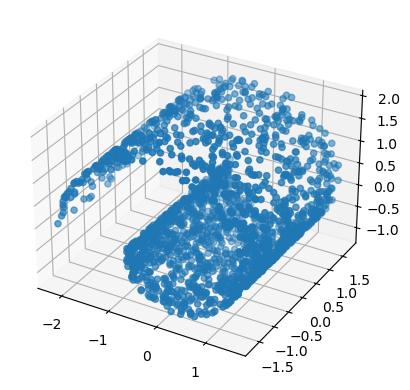

In [181]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = data["data"][:,0]
z = data["data"][:,1]
y = data["data"][:,2]
ax.scatter(x, y, z)

## Using SwissRoll Regression data for demonstration

In [183]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
X = data["data"]
Y = data["Y"]
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

In [188]:
#fitting S-kernel with raw data
skernel_pred = skelKernel(trainX, trainY,  testX)
mean_squared_error(testY, skernel_pred)

In [ ]:
#fitting S-Lspline with raw data
lspline = skelLspline(trainX, trainY,  testX)
mean_squared_error(testY, lspline["pred"])

In [194]:
#fitting S-Lspline with the pipeline of the framework
#1. construct skeleton
skeleton = Skeleton_Construction(trainX)
#2. segment skeleton based on skeleton-based edge weights
skeleton = segment_Skeleton(skeleton)
#3. project trainning and testing data onto the skeleton
trainnn = skeleton["nn"]
trainpx = skelProject(trainX, skeleton, nn = trainnn)
nbrs = NearestNeighbors(n_neighbors=2).fit(skeleton["centers"])
testnn = nbrs.kneighbors(testX, return_distance=False) #2-nearest neighbor calculation
testpx=skelProject(testX, skeleton, nn = testnn)
#4. fitting regression model
lspline = skelLinear(testnn, testpx, trainnn, trainpx, trainY, skeleton)